In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Flatten)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess_input


from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, roc_curve, auc, precision_score, recall_score)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_v2_preprocess_input


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split


import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau



import os
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, callbacks

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

2024-12-23 02:49:15.926517: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-23 02:49:16.148637: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-23 02:49:16.914379: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/abdo/miniconda3/envs/tf/lib/
2024-12-23 02:49:16.915447: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-12-23 02:49:29.450816: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-23 02:49:29.468353: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-23 02:49:29.468431: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
# Common settings
base_dir = '../Data/raw/5'
img_height, img_width = 224, 224
batch_size = 32

def random_contrast(image):
    contrast_factor = tf.random.uniform([], 0.5, 1.5)
    image = tf.image.adjust_contrast(image, contrast_factor)
    return image

# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=30,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.1,
    # zoom_range=0.1,
    # horizontal_flip=True,
    # fill_mode='nearest',
    validation_split=0.2,  # Increased to 0.2 for a clearer split
    preprocessing_function=random_contrast
)

# Validation data generator
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use the same split as train_datagen
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
validation_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # Specify 'validation' subset
    shuffle=False
)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


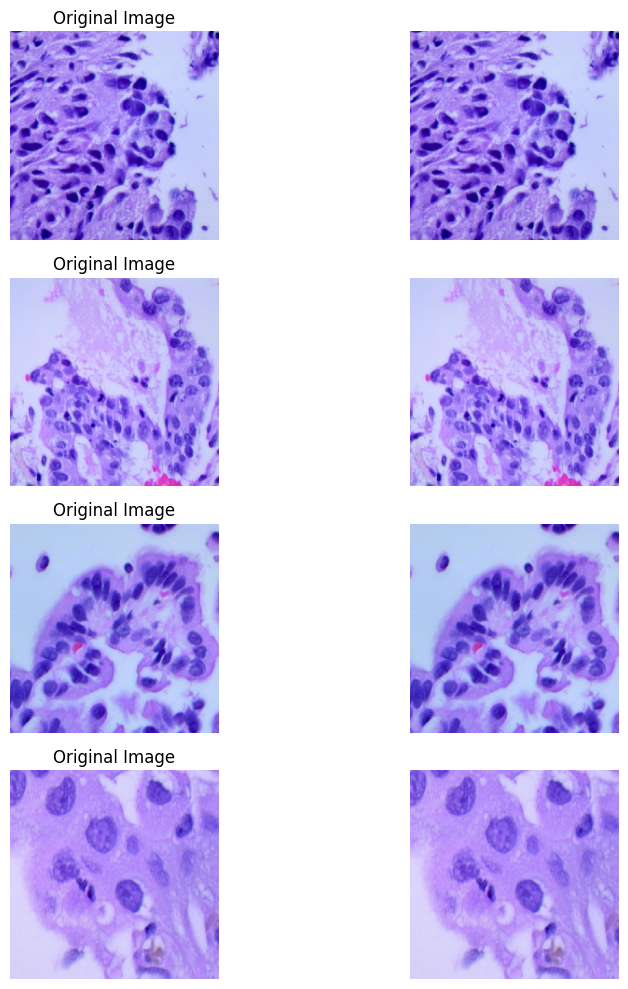

In [7]:
def display_images(generator, num_images=4):
    fig, axs = plt.subplots(nrows=num_images, ncols=2, figsize=(10, 10))
    axs = axs.flatten()

    for i in range(num_images):
        img, label = next(generator)
        axs[2*i].imshow(img[0])
        axs[2*i].set_title('Original Image')
        axs[2*i].axis('off')

        axs[2*i+1].imshow(img[0])
        # axs[2*i+1].set_title('Augmented Image')
        axs[2*i+1].axis('off')

    plt.tight_layout()
    plt.show()

# Display original and augmented images for validation data
display_images(validation_generator)

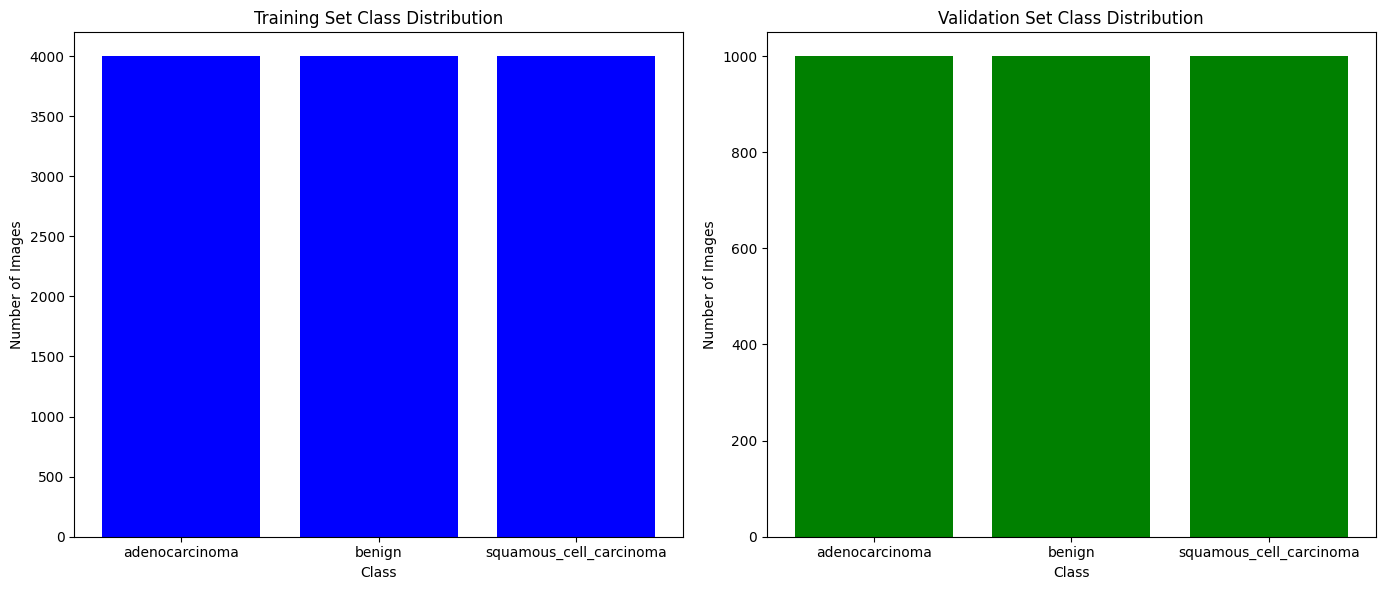

In [8]:
train_class_indices = train_generator.class_indices
validation_class_indices = validation_generator.class_indices

# Get the class labels
class_labels = list(train_class_indices.keys())

# Count the number of images per class in training and validation sets
train_counts = np.zeros(len(class_labels))
validation_counts = np.zeros(len(class_labels))

for i, label in enumerate(train_generator.classes):
    train_counts[label] += 1

for i, label in enumerate(validation_generator.classes):
    validation_counts[label] += 1

# Plot the distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].bar(class_labels, train_counts, color='blue')
ax[0].set_title('Training Set Class Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Images')

ax[1].bar(class_labels, validation_counts, color='green')
ax[1].set_title('Validation Set Class Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()

In [9]:
# Function to get image shapes
def get_image_shapes(generator):
    shapes = []
    for i in range(len(generator)):
        images, _ = generator[i]
        for img in images:
            shapes.append(img.shape)
    return np.array(shapes)

# Get shapes for training and validation sets
train_shapes = get_image_shapes(train_generator)
validation_shapes = get_image_shapes(validation_generator)

# Calculate statistics
def calculate_statistics(shapes):
    unique_shapes = np.unique(shapes, axis=0)
    min_dimensions = np.min(shapes, axis=0)
    max_dimensions = np.max(shapes, axis=0)
    mean_dimensions = np.mean(shapes, axis=0)
    return unique_shapes, min_dimensions, max_dimensions, mean_dimensions

train_unique_shapes, train_min_dimensions, train_max_dimensions, train_mean_dimensions = calculate_statistics(train_shapes)
validation_unique_shapes, validation_min_dimensions, validation_max_dimensions, validation_mean_dimensions = calculate_statistics(validation_shapes)

# Print statistics
print("Training Dataset:")
print(f"Number of images: {len(train_shapes)}")
print(f"Unique shapes: {train_unique_shapes}")
print(f"Min dimensions: {train_min_dimensions}")
print(f"Max dimensions: {train_max_dimensions}")
print(f"Mean dimensions: {train_mean_dimensions}")

print("\nValidation Dataset:")
print(f"Number of images: {len(validation_shapes)}")
print(f"Unique shapes: {validation_unique_shapes}")
print(f"Min dimensions: {validation_min_dimensions}")
print(f"Max dimensions: {validation_max_dimensions}")
print(f"Mean dimensions: {validation_mean_dimensions}")

2024-12-23 02:50:55.359556: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-23 02:50:55.365249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-23 02:50:55.365412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-23 02:50:55.365467: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

Training Dataset:
Number of images: 12000
Unique shapes: [[224 224   3]]
Min dimensions: [224 224   3]
Max dimensions: [224 224   3]
Mean dimensions: [224. 224.   3.]

Validation Dataset:
Number of images: 3000
Unique shapes: [[224 224   3]]
Min dimensions: [224 224   3]
Max dimensions: [224 224   3]
Mean dimensions: [224. 224.   3.]


In [10]:
# Load the ResNet50 model, excluding the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [11]:
# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
check_point = ModelCheckpoint('../models/best_model.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

In [12]:
# Train the model with callbacks
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping, check_point]
)

Epoch 1/10


2024-12-23 02:56:37.907949: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-12-23 02:56:46.186713: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-23 02:56:46.376770: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-23 02:56:46.376877: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-12-23 02:56:46.560678: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-23 02:56:46.560848: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-12-23 02:56:52.200571: I tensorflow/stream_executor/cuda/c

375/375 [==============================] - 352s 845ms/step - loss: 0.1112 - accuracy: 0.9558 - val_loss: 4.8965 - val_accuracy: 0.3563
Epoch 2/10
375/375 [==============================] - 250s 666ms/step - loss: 0.0343 - accuracy: 0.9896 - val_loss: 0.4370 - val_accuracy: 0.8520
Epoch 3/10
375/375 [==============================] - 243s 647ms/step - loss: 0.0332 - accuracy: 0.9897 - val_loss: 0.0230 - val_accuracy: 0.9923
Epoch 4/10
375/375 [==============================] - 239s 637ms/step - loss: 0.0159 - accuracy: 0.9943 - val_loss: 0.1587 - val_accuracy: 0.9867
Epoch 5/10
375/375 [==============================] - 240s 639ms/step - loss: 0.0127 - accuracy: 0.9957 - val_loss: 0.2537 - val_accuracy: 0.9300
Epoch 6/10
375/375 [==============================] - 236s 629ms/step - loss: 0.0134 - accuracy: 0.9961 - val_loss: 0.0531 - val_accuracy: 0.9810


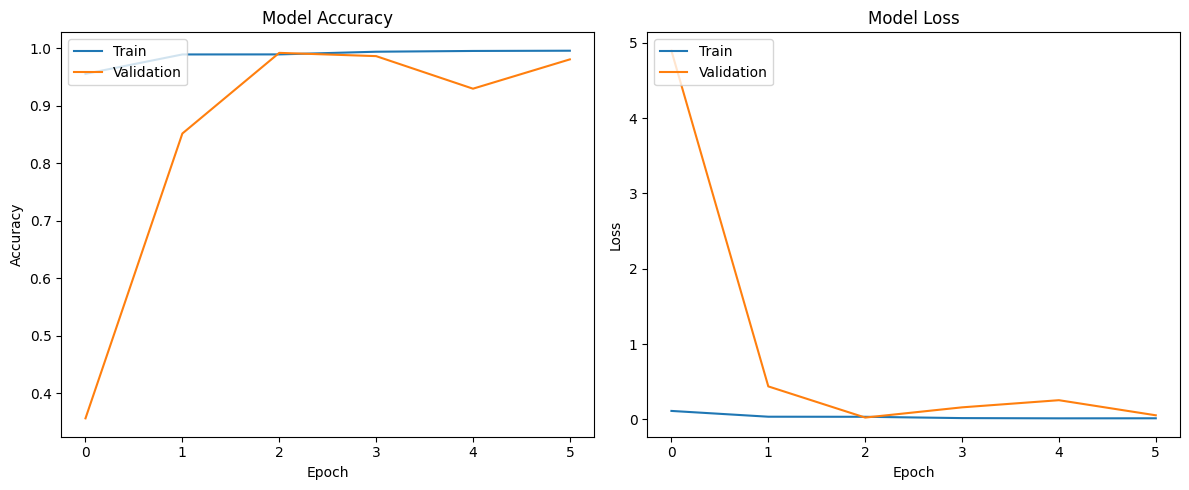

In [13]:
# Function to plot training history
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

Evaluating the model on the validation set...
94/94 [==============================] - 25s 259ms/step - loss: 0.0230 - accuracy: 0.9923
Validation Accuracy: 99.23%
Weighted F1 Score: 0.9923
Weighted Precision: 0.9923
Weighted Recall: 0.9923
Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       0.99      0.99      0.99      1000
                 benign       1.00      1.00      1.00      1000
squamous_cell_carcinoma       0.99      0.99      0.99      1000

               accuracy                           0.99      3000
              macro avg       0.99      0.99      0.99      3000
           weighted avg       0.99      0.99      0.99      3000



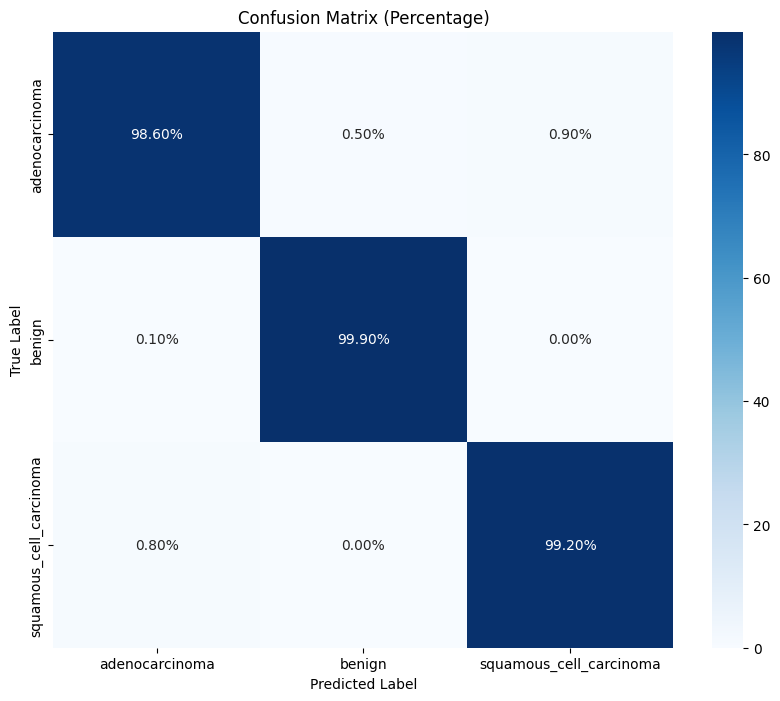

In [14]:


MODEL_NAME = "lung_cancer-resnet50-224"
OUTPUT_CONFUSION_MATRICES_DIR = os.path.join('../output/confusion_matrices/', MODEL_NAME)
os.makedirs(OUTPUT_CONFUSION_MATRICES_DIR, exist_ok=True)
OUTPUT_EVALUATION_METRICS_DIR = os.path.join('../output/evaluation_metrics/', MODEL_NAME)
os.makedirs(OUTPUT_EVALUATION_METRICS_DIR, exist_ok=True)


# Evaluate the model on the validation data
print("Evaluating the model on the validation set...")
validation_generator.reset()  # Reset the generator to ensure predictions are correct
Y_pred_prob = model.predict(validation_generator, verbose=1)
Y_pred = np.argmax(Y_pred_prob, axis=1)
Y_true = validation_generator.classes

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

# Calculate evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Calculate metrics
evaluation_accuracy = model.evaluate(validation_generator, verbose=1)[1]
f1 = f1_score(Y_true, Y_pred, average='weighted')
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
print(f"Validation Accuracy: {evaluation_accuracy*100:.2f}%")
print(f"Weighted F1 Score: {f1:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(Y_true, Y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(Y_true, Y_pred)

# Confusion matrix with percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cm_percentage = np.nan_to_num(cm_percentage)

# Prepare annotations with percentage symbol
annot_labels = np.empty_like(cm_percentage).astype(str)
nrows, ncols = cm_percentage.shape
for i in range(nrows):
    for j in range(ncols):
        annot_labels[i, j] = f'{cm_percentage[i, j]:.2f}%'

plt.figure(figsize=(10,8))
sns.heatmap(cm_percentage, annot=annot_labels, fmt='', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# Save confusion matrix
OUTPUT_CONFUSION_MATRICES_DIR = '../output/confusion_matrices/' + MODEL_NAME
os.makedirs(OUTPUT_CONFUSION_MATRICES_DIR, exist_ok=True)
confusion_matrix_path = os.path.join(OUTPUT_CONFUSION_MATRICES_DIR, 'confusion_matrix_percentage.png')
plt.savefig(confusion_matrix_path)
plt.show()

# Save evaluation metrics to CSV
import pandas as pd
metrics_data = {
    'Metric': ['Validation Accuracy', 'Weighted F1 Score', 'Weighted Precision', 'Weighted Recall'],
    'Value': [evaluation_accuracy, f1, precision, recall]
}
metrics_df = pd.DataFrame(metrics_data)
OUTPUT_EVALUATION_METRICS_DIR = '../output/evaluation_metrics/' + MODEL_NAME
os.makedirs(OUTPUT_EVALUATION_METRICS_DIR, exist_ok=True)
metrics_csv_path = os.path.join(OUTPUT_EVALUATION_METRICS_DIR, 'metrics.csv')
metrics_df.to_csv(metrics_csv_path, index=False)

# Save the final model
MODEL_DIR = '../models/' + MODEL_NAME
os.makedirs(MODEL_DIR, exist_ok=True)
model.save(os.path.join(MODEL_DIR, 'model_final.h5'))

In [18]:
# Common settings
base_dir = '../Data/raw/5'
img_height, img_width = 224, 224
batch_size = 32

def random_contrast(image):
    contrast_factor = tf.random.uniform([], 0.5, 1.5)
    image = tf.image.adjust_contrast(image, contrast_factor)
    return image

# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,  # Increased to 0.2 for a clearer split
    preprocessing_function=random_contrast
)

# Validation data generator
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use the same split as train_datagen
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
validation_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # Specify 'validation' subset
    shuffle=False
)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


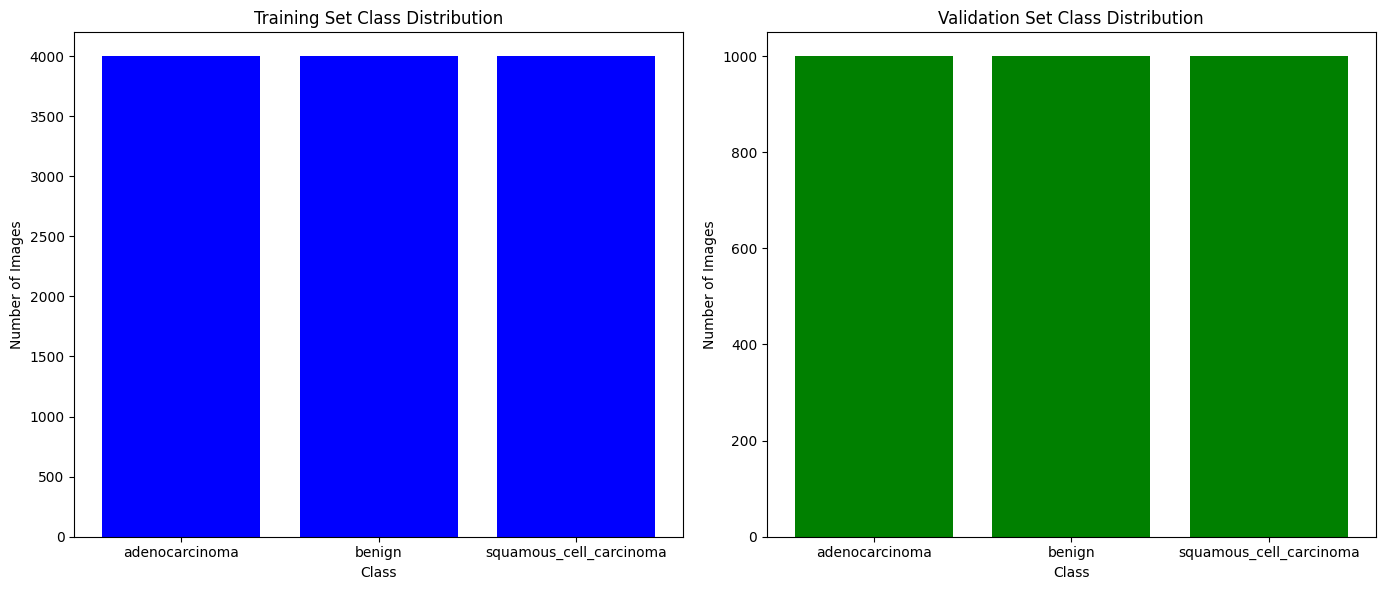

Training Dataset:
Number of images: 12000
Unique shapes: [[224 224   3]]
Min dimensions: [224 224   3]
Max dimensions: [224 224   3]
Mean dimensions: [224. 224.   3.]

Validation Dataset:
Number of images: 3000
Unique shapes: [[224 224   3]]
Min dimensions: [224 224   3]
Max dimensions: [224 224   3]
Mean dimensions: [224. 224.   3.]
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                     

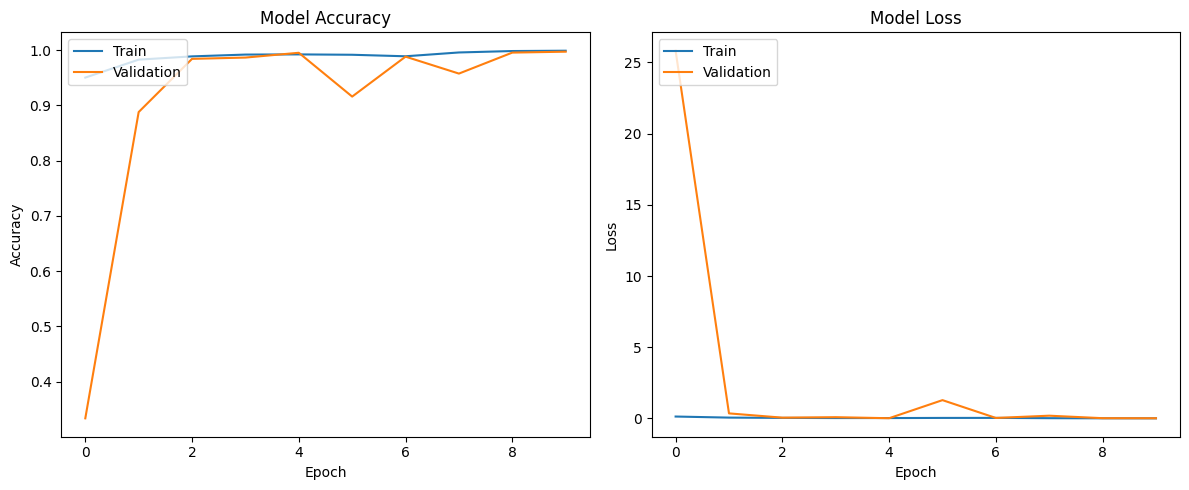

Evaluating the model on the validation set...
94/94 [==============================] - 23s 248ms/step - loss: 0.0096 - accuracy: 0.9973
Validation Accuracy: 99.73%
Weighted F1 Score: 0.9973
Weighted Precision: 0.9974
Weighted Recall: 0.9973
Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       1.00      0.99      1.00      1000
                 benign       1.00      1.00      1.00      1000
squamous_cell_carcinoma       0.99      1.00      1.00      1000

               accuracy                           1.00      3000
              macro avg       1.00      1.00      1.00      3000
           weighted avg       1.00      1.00      1.00      3000



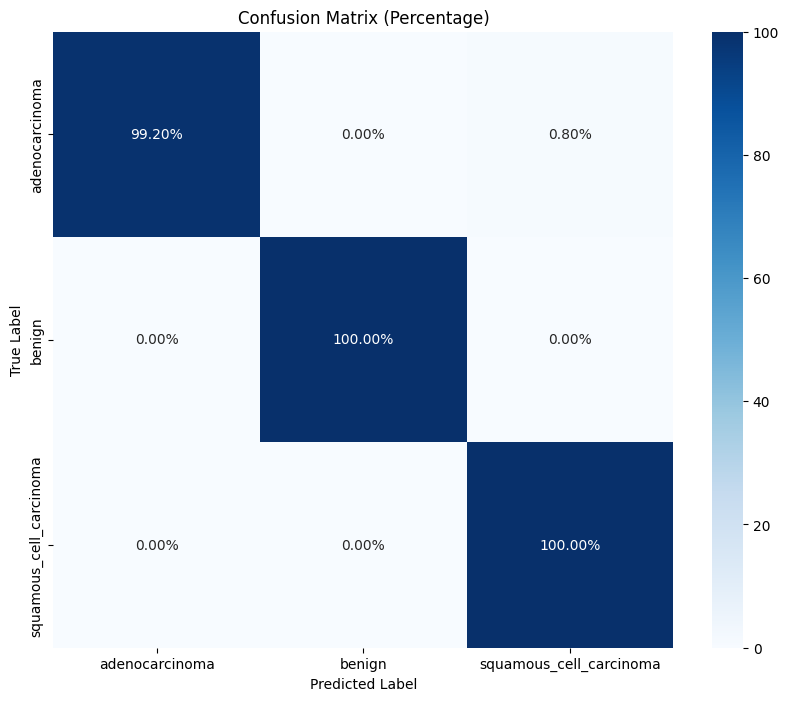

In [19]:
train_class_indices = train_generator.class_indices
validation_class_indices = validation_generator.class_indices

# Get the class labels
class_labels = list(train_class_indices.keys())

# Count the number of images per class in training and validation sets
train_counts = np.zeros(len(class_labels))
validation_counts = np.zeros(len(class_labels))

for i, label in enumerate(train_generator.classes):
    train_counts[label] += 1

for i, label in enumerate(validation_generator.classes):
    validation_counts[label] += 1

# Plot the distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].bar(class_labels, train_counts, color='blue')
ax[0].set_title('Training Set Class Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Images')

ax[1].bar(class_labels, validation_counts, color='green')
ax[1].set_title('Validation Set Class Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()

# Function to get image shapes
def get_image_shapes(generator):
    shapes = []
    for i in range(len(generator)):
        images, _ = generator[i]
        for img in images:
            shapes.append(img.shape)
    return np.array(shapes)

# Get shapes for training and validation sets
train_shapes = get_image_shapes(train_generator)
validation_shapes = get_image_shapes(validation_generator)

# Calculate statistics
def calculate_statistics(shapes):
    unique_shapes = np.unique(shapes, axis=0)
    min_dimensions = np.min(shapes, axis=0)
    max_dimensions = np.max(shapes, axis=0)
    mean_dimensions = np.mean(shapes, axis=0)
    return unique_shapes, min_dimensions, max_dimensions, mean_dimensions

train_unique_shapes, train_min_dimensions, train_max_dimensions, train_mean_dimensions = calculate_statistics(train_shapes)
validation_unique_shapes, validation_min_dimensions, validation_max_dimensions, validation_mean_dimensions = calculate_statistics(validation_shapes)

# Print statistics
print("Training Dataset:")
print(f"Number of images: {len(train_shapes)}")
print(f"Unique shapes: {train_unique_shapes}")
print(f"Min dimensions: {train_min_dimensions}")
print(f"Max dimensions: {train_max_dimensions}")
print(f"Mean dimensions: {train_mean_dimensions}")

print("\nValidation Dataset:")
print(f"Number of images: {len(validation_shapes)}")
print(f"Unique shapes: {validation_unique_shapes}")
print(f"Min dimensions: {validation_min_dimensions}")
print(f"Max dimensions: {validation_max_dimensions}")
print(f"Mean dimensions: {validation_mean_dimensions}")


# Load the ResNet50 model, excluding the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.summary()



# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
check_point = ModelCheckpoint('../models/best_model.h5', save_best_only=True)


# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
check_point = ModelCheckpoint('../models/best_model.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)



# Train the model with callbacks
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping, check_point, reduce_lr]
)


# Function to plot training history
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)


MODEL_NAME = "lung_cancer-resnet50-augmneted-224"
OUTPUT_CONFUSION_MATRICES_DIR = os.path.join('../output/confusion_matrices/', MODEL_NAME)
os.makedirs(OUTPUT_CONFUSION_MATRICES_DIR, exist_ok=True)
OUTPUT_EVALUATION_METRICS_DIR = os.path.join('../output/evaluation_metrics/', MODEL_NAME)
os.makedirs(OUTPUT_EVALUATION_METRICS_DIR, exist_ok=True)


# Evaluate the model on the validation data
print("Evaluating the model on the validation set...")
validation_generator.reset()  # Reset the generator to ensure predictions are correct
Y_pred_prob = model.predict(validation_generator, verbose=1)
Y_pred = np.argmax(Y_pred_prob, axis=1)
Y_true = validation_generator.classes

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

# Calculate evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Calculate metrics
evaluation_accuracy = model.evaluate(validation_generator, verbose=1)[1]
f1 = f1_score(Y_true, Y_pred, average='weighted')
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
print(f"Validation Accuracy: {evaluation_accuracy*100:.2f}%")
print(f"Weighted F1 Score: {f1:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(Y_true, Y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(Y_true, Y_pred)

# Confusion matrix with percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cm_percentage = np.nan_to_num(cm_percentage)

# Prepare annotations with percentage symbol
annot_labels = np.empty_like(cm_percentage).astype(str)
nrows, ncols = cm_percentage.shape
for i in range(nrows):
    for j in range(ncols):
        annot_labels[i, j] = f'{cm_percentage[i, j]:.2f}%'

plt.figure(figsize=(10,8))
sns.heatmap(cm_percentage, annot=annot_labels, fmt='', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# Save confusion matrix
OUTPUT_CONFUSION_MATRICES_DIR = '../output/confusion_matrices/' + MODEL_NAME
os.makedirs(OUTPUT_CONFUSION_MATRICES_DIR, exist_ok=True)
confusion_matrix_path = os.path.join(OUTPUT_CONFUSION_MATRICES_DIR, 'confusion_matrix_percentage.png')
plt.savefig(confusion_matrix_path)
plt.show()

# Save evaluation metrics to CSV
import pandas as pd
metrics_data = {
    'Metric': ['Validation Accuracy', 'Weighted F1 Score', 'Weighted Precision', 'Weighted Recall'],
    'Value': [evaluation_accuracy, f1, precision, recall]
}
metrics_df = pd.DataFrame(metrics_data)
OUTPUT_EVALUATION_METRICS_DIR = '../output/evaluation_metrics/' + MODEL_NAME
os.makedirs(OUTPUT_EVALUATION_METRICS_DIR, exist_ok=True)
metrics_csv_path = os.path.join(OUTPUT_EVALUATION_METRICS_DIR, 'metrics.csv')
metrics_df.to_csv(metrics_csv_path, index=False)

# Save the final model
MODEL_DIR = '../models/' + MODEL_NAME
os.makedirs(MODEL_DIR, exist_ok=True)
model.save(os.path.join(MODEL_DIR, 'model_final.h5'))

In [20]:
# Common settings
base_dir = '../Data/raw/5'
img_height, img_width = 224, 224
batch_size = 32

def random_contrast(image):
    contrast_factor = tf.random.uniform([], 0.5, 1.5)
    image = tf.image.adjust_contrast(image, contrast_factor)
    return image

# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=30,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.1,
    # zoom_range=0.1,
    # horizontal_flip=True,
    # fill_mode='nearest',
    validation_split=0.2,  # Increased to 0.2 for a clearer split
    preprocessing_function=random_contrast
)

# Validation data generator
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use the same split as train_datagen
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
validation_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # Specify 'validation' subset
    shuffle=False
)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


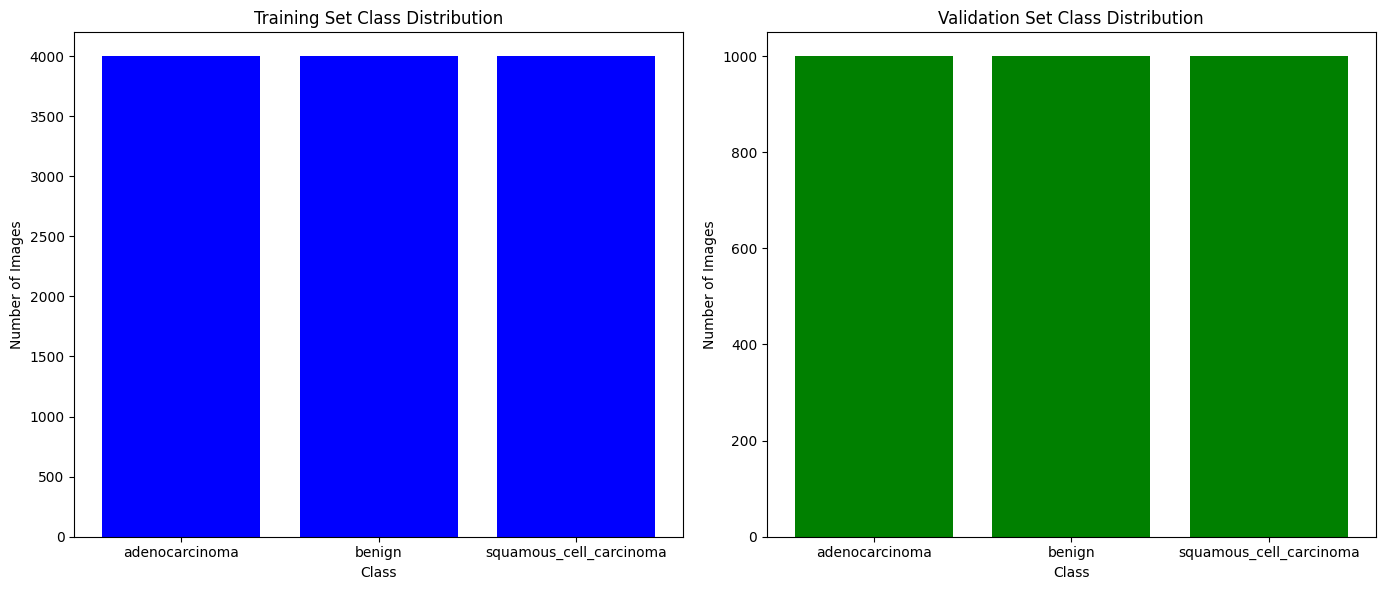

Training Dataset:
Number of images: 12000
Unique shapes: [[150 150   3]]
Min dimensions: [150 150   3]
Max dimensions: [150 150   3]
Mean dimensions: [150. 150.   3.]

Validation Dataset:
Number of images: 3000
Unique shapes: [[150 150   3]]
Min dimensions: [150 150   3]
Max dimensions: [150 150   3]
Mean dimensions: [150. 150.   3.]
29084464/29084464 [==============================] - 52s 2us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0          ['input_6[0][0]']    

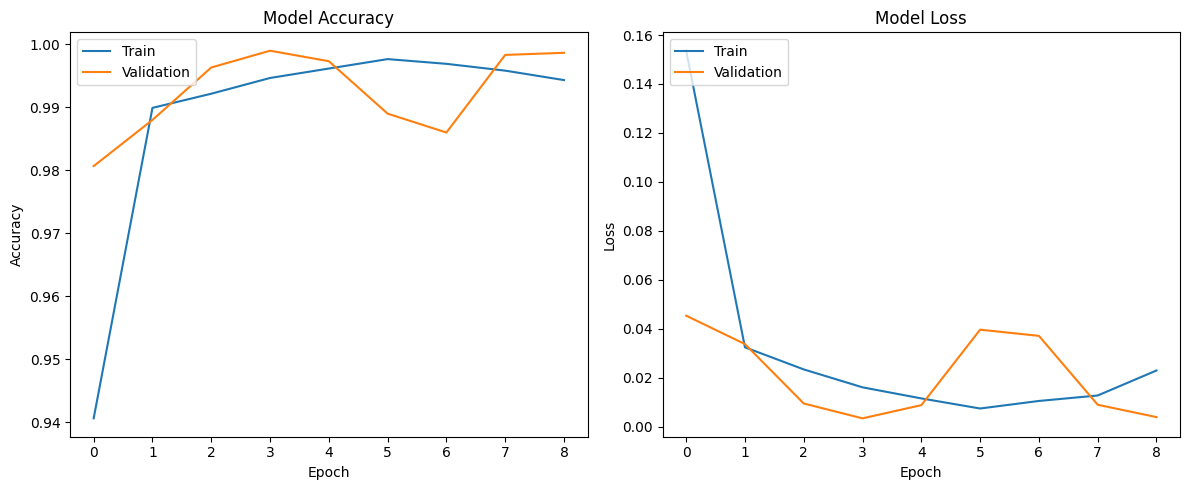

Evaluating the model on the validation set...
94/94 [==============================] - 23s 247ms/step - loss: 0.0034 - accuracy: 0.9990
Validation Accuracy: 99.90%
Weighted F1 Score: 0.9990
Weighted Precision: 0.9990
Weighted Recall: 0.9990
Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       1.00      1.00      1.00      1000
                 benign       1.00      1.00      1.00      1000
squamous_cell_carcinoma       1.00      1.00      1.00      1000

               accuracy                           1.00      3000
              macro avg       1.00      1.00      1.00      3000
           weighted avg       1.00      1.00      1.00      3000



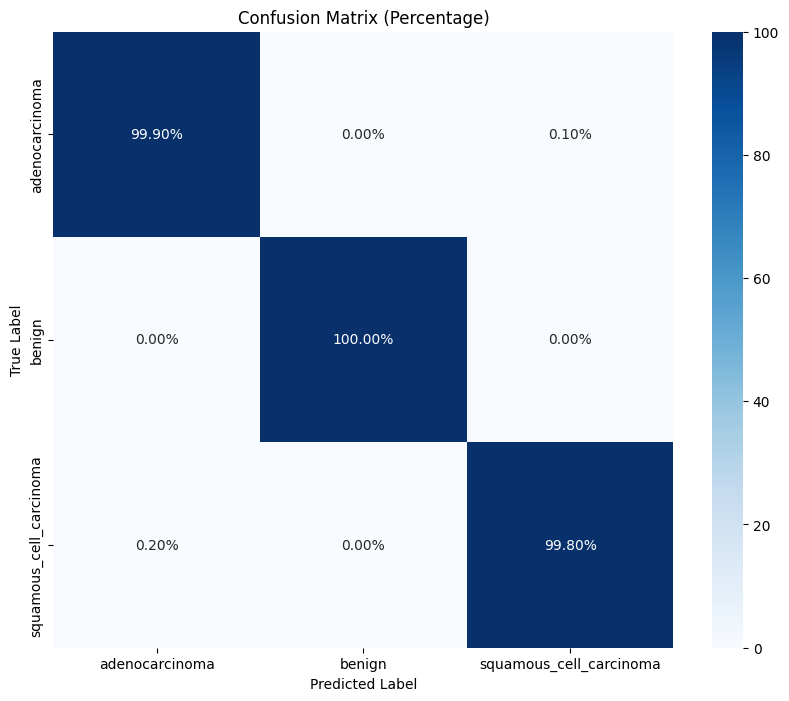

In [29]:
train_class_indices = train_generator.class_indices
validation_class_indices = validation_generator.class_indices

# Get the class labels
class_labels = list(train_class_indices.keys())

# Count the number of images per class in training and validation sets
train_counts = np.zeros(len(class_labels))
validation_counts = np.zeros(len(class_labels))

for i, label in enumerate(train_generator.classes):
    train_counts[label] += 1

for i, label in enumerate(validation_generator.classes):
    validation_counts[label] += 1

# Plot the distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].bar(class_labels, train_counts, color='blue')
ax[0].set_title('Training Set Class Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Images')

ax[1].bar(class_labels, validation_counts, color='green')
ax[1].set_title('Validation Set Class Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()

# Function to get image shapes
def get_image_shapes(generator):
    shapes = []
    for i in range(len(generator)):
        images, _ = generator[i]
        for img in images:
            shapes.append(img.shape)
    return np.array(shapes)

# Get shapes for training and validation sets
train_shapes = get_image_shapes(train_generator)
validation_shapes = get_image_shapes(validation_generator)

# Calculate statistics
def calculate_statistics(shapes):
    unique_shapes = np.unique(shapes, axis=0)
    min_dimensions = np.min(shapes, axis=0)
    max_dimensions = np.max(shapes, axis=0)
    mean_dimensions = np.mean(shapes, axis=0)
    return unique_shapes, min_dimensions, max_dimensions, mean_dimensions

train_unique_shapes, train_min_dimensions, train_max_dimensions, train_mean_dimensions = calculate_statistics(train_shapes)
validation_unique_shapes, validation_min_dimensions, validation_max_dimensions, validation_mean_dimensions = calculate_statistics(validation_shapes)

# Print statistics
print("Training Dataset:")
print(f"Number of images: {len(train_shapes)}")
print(f"Unique shapes: {train_unique_shapes}")
print(f"Min dimensions: {train_min_dimensions}")
print(f"Max dimensions: {train_max_dimensions}")
print(f"Mean dimensions: {train_mean_dimensions}")

print("\nValidation Dataset:")
print(f"Number of images: {len(validation_shapes)}")
print(f"Unique shapes: {validation_unique_shapes}")
print(f"Min dimensions: {validation_min_dimensions}")
print(f"Max dimensions: {validation_max_dimensions}")
print(f"Mean dimensions: {validation_mean_dimensions}")


# Load the DenseNet121 model, excluding the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.summary()



# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
check_point = ModelCheckpoint('../models/best_model.h5', save_best_only=True)


# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
check_point = ModelCheckpoint('../models/best_model.h5', save_best_only=True)



# Train the model with callbacks
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping, check_point]
)


# Function to plot training history
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)


MODEL_NAME = "lung_cancer-densenet121-224"
OUTPUT_CONFUSION_MATRICES_DIR = os.path.join('../output/confusion_matrices/', MODEL_NAME)
os.makedirs(OUTPUT_CONFUSION_MATRICES_DIR, exist_ok=True)
OUTPUT_EVALUATION_METRICS_DIR = os.path.join('../output/evaluation_metrics/', MODEL_NAME)
os.makedirs(OUTPUT_EVALUATION_METRICS_DIR, exist_ok=True)


# Evaluate the model on the validation data
print("Evaluating the model on the validation set...")
validation_generator.reset()  # Reset the generator to ensure predictions are correct
Y_pred_prob = model.predict(validation_generator, verbose=1)
Y_pred = np.argmax(Y_pred_prob, axis=1)
Y_true = validation_generator.classes

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

# Calculate evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Calculate metrics
evaluation_accuracy = model.evaluate(validation_generator, verbose=1)[1]
f1 = f1_score(Y_true, Y_pred, average='weighted')
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
print(f"Validation Accuracy: {evaluation_accuracy*100:.2f}%")
print(f"Weighted F1 Score: {f1:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(Y_true, Y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(Y_true, Y_pred)

# Confusion matrix with percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cm_percentage = np.nan_to_num(cm_percentage)

# Prepare annotations with percentage symbol
annot_labels = np.empty_like(cm_percentage).astype(str)
nrows, ncols = cm_percentage.shape
for i in range(nrows):
    for j in range(ncols):
        annot_labels[i, j] = f'{cm_percentage[i, j]:.2f}%'

plt.figure(figsize=(10,8))
sns.heatmap(cm_percentage, annot=annot_labels, fmt='', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# Save confusion matrix
OUTPUT_CONFUSION_MATRICES_DIR = '../output/confusion_matrices/' + MODEL_NAME
os.makedirs(OUTPUT_CONFUSION_MATRICES_DIR, exist_ok=True)
confusion_matrix_path = os.path.join(OUTPUT_CONFUSION_MATRICES_DIR, 'confusion_matrix_percentage.png')
plt.savefig(confusion_matrix_path)
plt.show()

# Save evaluation metrics to CSV
import pandas as pd
metrics_data = {
    'Metric': ['Validation Accuracy', 'Weighted F1 Score', 'Weighted Precision', 'Weighted Recall'],
    'Value': [evaluation_accuracy, f1, precision, recall]
}
metrics_df = pd.DataFrame(metrics_data)
OUTPUT_EVALUATION_METRICS_DIR = '../output/evaluation_metrics/' + MODEL_NAME
os.makedirs(OUTPUT_EVALUATION_METRICS_DIR, exist_ok=True)
metrics_csv_path = os.path.join(OUTPUT_EVALUATION_METRICS_DIR, 'metrics.csv')
metrics_df.to_csv(metrics_csv_path, index=False)

# Save the final model
MODEL_DIR = '../models/' + MODEL_NAME
os.makedirs(MODEL_DIR, exist_ok=True)
model.save(os.path.join(MODEL_DIR, 'model_final.h5'))

In [15]:
# Common settings
base_dir = '../Data/raw/5'
img_height, img_width = 224, 224
batch_size = 32

def random_contrast(image):
    contrast_factor = tf.random.uniform([], 0.5, 1.5)
    image = tf.image.adjust_contrast(image, contrast_factor)
    return image

# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,  # Increased to 0.2 for a clearer split
    preprocessing_function=random_contrast
)

# Validation data generator
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use the same split as train_datagen
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
validation_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # Specify 'validation' subset
    shuffle=False
)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


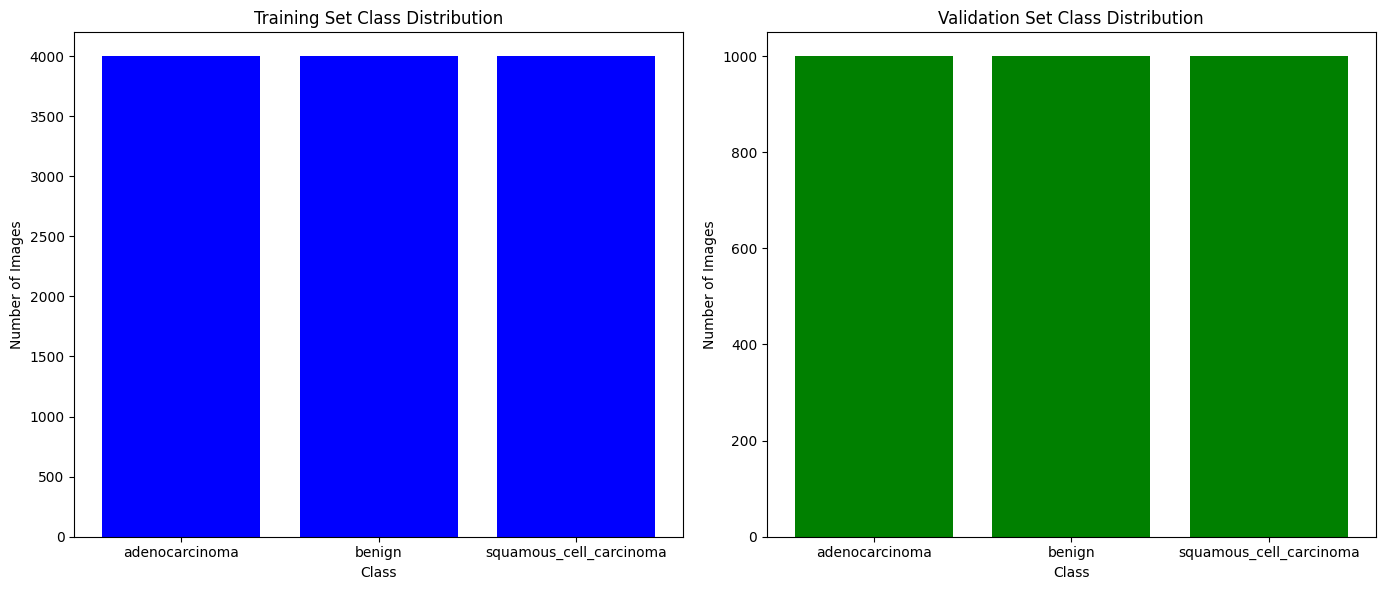

Training Dataset:
Number of images: 12000
Unique shapes: [[224 224   3]]
Min dimensions: [224 224   3]
Max dimensions: [224 224   3]
Mean dimensions: [224. 224.   3.]

Validation Dataset:
Number of images: 3000
Unique shapes: [[224 224   3]]
Min dimensions: [224 224   3]
Max dimensions: [224 224   3]
Mean dimensions: [224. 224.   3.]
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_3[0][0]']                
 D)                                                  

2024-12-23 03:38:16.342023: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 49.00MiB (rounded to 51380224)requested by op model_2/pool3_bn/FusedBatchNormV3
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-12-23 03:38:16.342232: I tensorflow/core/common_runtime/bfc_allocator.cc:1033] BFCAllocator dump for GPU_0_bfc
2024-12-23 03:38:16.342255: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (256): 	Total Chunks: 269, Chunks in use: 268. 67.2KiB allocated for chunks. 67.0KiB in use in bin. 29.2KiB client-requested in use in bin.
2024-12-23 03:38:16.342266: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (512): 	Total Chunks: 1178, Chunks in use: 1177. 608.0KiB allocated for chunks. 607.5KiB in use in bin. 596.9KiB client-requested in use in 

ResourceExhaustedError: Graph execution error:

Detected at node 'model_2/pool3_bn/FusedBatchNormV3' defined at (most recent call last):
    File "/home/abdo/miniconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/abdo/miniconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/abdo/.local/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "/home/abdo/.local/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/home/abdo/.local/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start
      self.io_loop.start()
    File "/home/abdo/.local/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "/home/abdo/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/abdo/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/abdo/miniconda3/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/abdo/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "/home/abdo/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "/home/abdo/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
      await result
    File "/home/abdo/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "/home/abdo/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "/home/abdo/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "/home/abdo/.local/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/abdo/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "/home/abdo/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "/home/abdo/.local/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/abdo/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/abdo/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/abdo/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_2078/2273162319.py", line 119, in <module>
      history = model.fit(
    File "/home/abdo/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/abdo/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/abdo/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "/home/abdo/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/abdo/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "/home/abdo/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "/home/abdo/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/abdo/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/abdo/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/abdo/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/abdo/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/abdo/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/abdo/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/abdo/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/abdo/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/abdo/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/abdo/miniconda3/envs/tf/lib/python3.9/site-packages/keras/layers/normalization/batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "/home/abdo/miniconda3/envs/tf/lib/python3.9/site-packages/keras/layers/normalization/batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "/home/abdo/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "/home/abdo/miniconda3/envs/tf/lib/python3.9/site-packages/keras/layers/normalization/batch_normalization.py", line 634, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model_2/pool3_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[32,512,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_2/pool3_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1388053]

In [17]:
train_class_indices = train_generator.class_indices
validation_class_indices = validation_generator.class_indices

# Get the class labels
class_labels = list(train_class_indices.keys())

# Count the number of images per class in training and validation sets
train_counts = np.zeros(len(class_labels))
validation_counts = np.zeros(len(class_labels))

for i, label in enumerate(train_generator.classes):
    train_counts[label] += 1

for i, label in enumerate(validation_generator.classes):
    validation_counts[label] += 1

# Plot the distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].bar(class_labels, train_counts, color='blue')
ax[0].set_title('Training Set Class Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Images')

ax[1].bar(class_labels, validation_counts, color='green')
ax[1].set_title('Validation Set Class Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()

# Function to get image shapes
def get_image_shapes(generator):
    shapes = []
    for i in range(len(generator)):
        images, _ = generator[i]
        for img in images:
            shapes.append(img.shape)
    return np.array(shapes)

# Get shapes for training and validation sets
train_shapes = get_image_shapes(train_generator)
validation_shapes = get_image_shapes(validation_generator)

# Calculate statistics
def calculate_statistics(shapes):
    unique_shapes = np.unique(shapes, axis=0)
    min_dimensions = np.min(shapes, axis=0)
    max_dimensions = np.max(shapes, axis=0)
    mean_dimensions = np.mean(shapes, axis=0)
    return unique_shapes, min_dimensions, max_dimensions, mean_dimensions

train_unique_shapes, train_min_dimensions, train_max_dimensions, train_mean_dimensions = calculate_statistics(train_shapes)
validation_unique_shapes, validation_min_dimensions, validation_max_dimensions, validation_mean_dimensions = calculate_statistics(validation_shapes)

# Print statistics
print("Training Dataset:")
print(f"Number of images: {len(train_shapes)}")
print(f"Unique shapes: {train_unique_shapes}")
print(f"Min dimensions: {train_min_dimensions}")
print(f"Max dimensions: {train_max_dimensions}")
print(f"Mean dimensions: {train_mean_dimensions}")

print("\nValidation Dataset:")
print(f"Number of images: {len(validation_shapes)}")
print(f"Unique shapes: {validation_unique_shapes}")
print(f"Min dimensions: {validation_min_dimensions}")
print(f"Max dimensions: {validation_max_dimensions}")
print(f"Mean dimensions: {validation_mean_dimensions}")


# Load the DenseNet121 model, excluding the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.summary()



# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
check_point = ModelCheckpoint('../models/best_model.h5', save_best_only=True)


# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
check_point = ModelCheckpoint('../models_reduce_lr/best_model.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min',min_lr=1e-6)



# Train the model with callbacks
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping, check_point, reduce_lr]
)


# Function to plot training history
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)


MODEL_NAME = "lung_cancer-densenet121-augmented-reduce_lr-224"
OUTPUT_CONFUSION_MATRICES_DIR = os.path.join('../output/confusion_matrices/', MODEL_NAME)
os.makedirs(OUTPUT_CONFUSION_MATRICES_DIR, exist_ok=True)
OUTPUT_EVALUATION_METRICS_DIR = os.path.join('../output/evaluation_metrics/', MODEL_NAME)
os.makedirs(OUTPUT_EVALUATION_METRICS_DIR, exist_ok=True)


# Evaluate the model on the validation data
print("Evaluating the model on the validation set...")
validation_generator.reset()  # Reset the generator to ensure predictions are correct
Y_pred_prob = model.predict(validation_generator, verbose=1)
Y_pred = np.argmax(Y_pred_prob, axis=1)
Y_true = validation_generator.classes

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

# Calculate evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Calculate metrics
evaluation_accuracy = model.evaluate(validation_generator, verbose=1)[1]
f1 = f1_score(Y_true, Y_pred, average='weighted')
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
print(f"Validation Accuracy: {evaluation_accuracy*100:.2f}%")
print(f"Weighted F1 Score: {f1:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(Y_true, Y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(Y_true, Y_pred)

# Confusion matrix with percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cm_percentage = np.nan_to_num(cm_percentage)

# Prepare annotations with percentage symbol
annot_labels = np.empty_like(cm_percentage).astype(str)
nrows, ncols = cm_percentage.shape
for i in range(nrows):
    for j in range(ncols):
        annot_labels[i, j] = f'{cm_percentage[i, j]:.2f}%'

plt.figure(figsize=(10,8))
sns.heatmap(cm_percentage, annot=annot_labels, fmt='', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# Save confusion matrix
OUTPUT_CONFUSION_MATRICES_DIR = '../output/confusion_matrices/' + MODEL_NAME
os.makedirs(OUTPUT_CONFUSION_MATRICES_DIR, exist_ok=True)
confusion_matrix_path = os.path.join(OUTPUT_CONFUSION_MATRICES_DIR, 'confusion_matrix_percentage.png')
plt.savefig(confusion_matrix_path)
plt.show()

# Save evaluation metrics to CSV
import pandas as pd
metrics_data = {
    'Metric': ['Validation Accuracy', 'Weighted F1 Score', 'Weighted Precision', 'Weighted Recall'],
    'Value': [evaluation_accuracy, f1, precision, recall]
}
metrics_df = pd.DataFrame(metrics_data)
OUTPUT_EVALUATION_METRICS_DIR = '../output/evaluation_metrics/' + MODEL_NAME
os.makedirs(OUTPUT_EVALUATION_METRICS_DIR, exist_ok=True)
metrics_csv_path = os.path.join(OUTPUT_EVALUATION_METRICS_DIR, 'metrics.csv')
metrics_df.to_csv(metrics_csv_path, index=False)

# Save the final model
MODEL_DIR = '../models/' + MODEL_NAME
os.makedirs(MODEL_DIR, exist_ok=True)
model.save(os.path.join(MODEL_DIR, 'model_final.h5'))